## Rain in Australia: Predict rain tomorrow in Australia

#### Developer: Anh Van
#### Email: ngockhueanhvan@gmail.com
Date: 30/09/2019
Version: 1.0
Environment: Python 3.5 and Jupyter Notebook

#### Introduction:
- Main purpose of this assignment is to predict probability of tomorrow rain in Australia using machine learning algorithms, including Desision Tree, Random Forest, Logistic Regression and GB Tree Classifier
- The procedure including:
    - Step 1: Import Spark Session and Loading data
    - Step 2: Load the dataset
    - Step 3: Delete columns
    - Step 4: Print the number of missing data
    - Step 5: Fill the missing data
    - Step 6: Data transformation
    - Step 7: Feature vetor and divide dataset 
    - Step 8: Machine learning algorithms
    - Step 9: Metrics

### Import libraries

In [1]:
# function operations in Spark dataframe
from pyspark.sql.functions import col, avg, when, count

# convert string variables into Numeric variables for machine learning algorithms
from pyspark.ml.feature import StringIndexer

# convert numeric variables into double type
from pyspark.sql.types import DoubleType

# pipeline
from pyspark.ml import Pipeline

# assemble independent variables into feature vector
from pyspark.ml.feature import VectorAssembler

# build evaluator for model performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

# Random Forest
from pyspark.ml.classification import RandomForestClassifier

# Logistic Regression
from pyspark.ml.classification import LogisticRegression

# Gradient Boosted Tree
from pyspark.ml.classification import GBTClassifier

# visualization
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Part A: Creating Spark Session and Loading the Data

### Step 1: Import Spark Session and initialize Spark
- In this section, we are going to create Spark Session, providing a single point of entry to interact with underlying Spark functionality and allowing programming Spark with Dataframe and Dataset APIs
- The Application Name is "Assignment 2"
- Spark is run locally with 4 processing cores

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# import libraries 
from pyspark import SparkConf, SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# create the SparkConf object
spark_conf = SparkConf()\
    .setMaster("local[4]")
    #.set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.1")


# local[4]: run Spark locally with 4 working processors as required.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# create the SparkSession object   
my_spark = SparkSession\
    .builder\
    .appName("Assignment 2")\
    .config(conf=spark_conf)\
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ass_2") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/ass_2") \
    .getOrCreate()

### Step 2: Load the dataset and print the schema and total number of entries
- In this section, we are going to load a csv dataset regarding weather in Australia into dataframe using spark session
- We are printing the schema and total number of entries

In [3]:
# load the data to dataframe using SparkSession
weather = my_spark.read.csv("weatherAUS.csv", header=True)

In [4]:
# print the total number of entries
entries = weather.count()
print("Total number of entries is", entries)

Total number of entries is 142193


In [5]:
# print the dataframe schema
weather.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



- Regarding the schema, we can see all of the columns of dataframe are string, which is apparently unusual. 
- For example, the MinTemp and Maxtemp are usually numeric. Let's print out the first few lines of dataframe to see the actual figures. 

In [6]:
# show the first five lines of dataframe
weather.show(5, truncate=False)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date      |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |No       |No          |
|2008-12-02|

- We can see many of them should have been numeric, i.e. MinTemp, MaxTemp, Rainfall, etc. instead of string. 
- Thus, we might need to convert data types of certain columns in latter steps.

## Part B: Data Cleaning and Processing

### Step 3: Delete columns from the dataset
- In this section, we are goin to delete some unnecessary data from the dataset to enhance efficiency and accuracy of our model
- We are going to delete the following columns:
    - Date
    - Location
    - Evaporation
    - Sunshine
    - Cloud9am
    - Cloud3pm
    - Temp9am
    - Temp3pm

In [7]:
# list of columns to be deleted
del_col = ['Date','Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# drop the above columns
weather = weather.drop(*del_col)

In [8]:
# print again the schema to check
weather.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



### Step 4: Print the number of missing data in each column
- In this section, we are going to find and print out the total number of null values in each column

In [9]:
# define a function to count 'NA' values for each column of the input datafram
def number_of_na(dataset):
    # declare the list of columns and their number of 'NA' values 
    na_list = []
    # list of features from the dataframe
    cols = dataset.columns
    # for each column, count the number of 'NA' and append to the na_list()
    for column in cols:
        na = dataset.where(col(column)=='NA').count()
        na_list.append((column,na))
    return na_list

In [10]:
# apply to our dataset
na_list = number_of_na(weather)
# print out the results
for each in na_list:
    column = each[0]
    na = each[1]
    print("- {0} has {1} null values".format(column, na))

- MinTemp has 637 null values
- MaxTemp has 322 null values
- Rainfall has 1406 null values
- WindGustDir has 9330 null values
- WindGustSpeed has 9270 null values
- WindDir9am has 10013 null values
- WindDir3pm has 3778 null values
- WindSpeed9am has 1348 null values
- WindSpeed3pm has 2630 null values
- Humidity9am has 1774 null values
- Humidity3pm has 3610 null values
- Pressure9am has 14014 null values
- Pressure3pm has 13981 null values
- RainToday has 1406 null values
- RainTomorrow has 0 null values


### Step 5: Fill the missing data with average value and maximum occurence value
- In this section, we are going to fill all the missing values with:
    - Average values for numeric columns
    - Maximum occurences for non-numeric columns

#### Find the numeric and non-numeric features
- First, we are going to identify which columns are numeric and none-numeric
- Here, if the result of average function are floats, then the feature is numeric
- Otherwise, the feature is non-numeric

In [11]:
# list of all features
all_col = weather.columns
# list of numeric features
numeric_col = []
# list of none-numeric features
none_numeric_col = []

# append each list the features from dataframe
for column in all_col:
    # calculate the average value of each column
    average = weather.groupby().agg(avg(column)).collect()[0][0]
    # if we have floats, then the feature is numeric
    if average != None:
        numeric_col.append((column, average))
    # elseif we have 'None', the feature is none-numeric
    else:
        none_numeric_col.append(column)

# print the numeric list
print("The numeric features are:")
for features in numeric_col:
    print("-", features[0])

# print the none-numeric list
print("\nThe none-numeric features are:")
for features in none_numeric_col:
    print("-", features)

The numeric features are:
- MinTemp
- MaxTemp
- Rainfall
- WindGustSpeed
- WindSpeed9am
- WindSpeed3pm
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm

The none-numeric features are:
- WindGustDir
- WindDir9am
- WindDir3pm
- RainToday
- RainTomorrow


#### Replace 'NA' values of numeric features with average values of each feature

In [12]:
# list of numeric features, where the first item is feature name and second item is average value
numeric_col

[('MinTemp', 12.186399728729311),
 ('MaxTemp', 23.2267841912725),
 ('Rainfall', 2.3499740743107442),
 ('WindGustSpeed', 39.98429165757619),
 ('WindSpeed9am', 14.001988000994),
 ('WindSpeed3pm', 18.63757586179718),
 ('Humidity9am', 68.8438103105705),
 ('Humidity3pm', 51.482606091656265),
 ('Pressure9am', 1017.6537584159615),
 ('Pressure3pm', 1015.2582035378894)]

In [13]:
# replace the 'NA' values of numeric features with average values of each feature
for column in numeric_col:
    col_name = column[0]
    avg_col = column[1]
    weather = weather.withColumn(col_name, when(weather[col_name]=='NA',avg_col).otherwise(weather[col_name]))

#### Replace 'NA' values of none-numeric features with the highest frequent values of each feature

In [14]:
# list of non-numeric features
non_col = []

for column in none_numeric_col:
    # count the occurences of each distinct word
    # sort the results from the higest to the lowest frequency
    aggr = weather.groupby(column).agg(count(column).alias('freq')).sort('freq', ascending=False)
    # the highest frequent item
    string = aggr.collect()[0][0]
    # the occurence of the item
    freq = aggr.collect()[0][1]
    # append to the list
    non_col.append((column, string, freq))

In [15]:
# list of non-numeric features, where the first item is feature name, 
# second item is the highest frequent word
# third item is the frequency
non_col

[('WindGustDir', 'W', 9780),
 ('WindDir9am', 'N', 11393),
 ('WindDir3pm', 'SE', 10663),
 ('RainToday', 'No', 109332),
 ('RainTomorrow', 'No', 110316)]

In [16]:
# Replace 'NA' values of none-numeric features with the highest frequent values of each feature
for column in non_col:
    col_name = column[0]
    highest_freq = column[1]
    weather = weather.withColumn(col_name, when(weather[col_name]=='NA',highest_freq).otherwise(weather[col_name]))

### Step 6: Data transformation
- In this section, we are going to transform the data so that it is ready to process by machine learning algorithm
- Convert numeric data into double type
- Convert non-numeric data into numbers using StringIndexer

In [17]:
# convert the numberic data into double using cast() function
for column in numeric_col:
    weather = weather.withColumn(column[0], col(column[0]).cast('double'))

In [18]:
# convert non-numeric data into numbers using StringIndexer 
indexers = [StringIndexer(inputCol=column, outputCol=column+"Index").fit(weather) for column in none_numeric_col]
pipeline = Pipeline(stages=indexers)
# fit to the dataframe
weather = pipeline.fit(weather).transform(weather)

In [19]:
# print schema after transformation
weather.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)
 |-- WindGustDirIndex: double (nullable = false)
 |-- WindDir9amIndex: double (nullable = false)
 |-- WindDir3pmIndex: double (nullable = false)
 |-- RainTodayIndex: double (nullable = false)
 |-- RainTomorrowIndex: double (nullable = false)



In [20]:
# display the top five lines
weather.show(5, False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+---------------+---------------+--------------+-----------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDirIndex|WindDir9amIndex|WindDir3pmIndex|RainTodayIndex|RainTomorrowIndex|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+---------------+---------------+--------------+-----------------+
|13.4   |22.9   |0.6     |W          |44.0         |W         |WNW       |20.0        |24.0        |71.0       |22.0       |1007.7     |1007.1     |No       |No          |0.0             |6.0            |7.0            |0.0           |0.0

### Step 7: Create the feature vector and divide the dataset
- In this section, we are going to create the feature vector from the given columns
- RainTomorrow_index should be excluded from the feature vector
- Next, dataset is randomly split into two parts, including 70% training data and 30% testing data

#### Create the feature vector from the given columns

In [21]:
# the columns to be excluded from the feature vector
ignore_cols = ['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow','RainTomorrowIndex']
# Assemble vector of features
assembler = VectorAssembler(inputCols=[x for x in weather.columns if x not in ignore_cols], outputCol='features')
assembler.transform(weather)

DataFrame[MinTemp: double, MaxTemp: double, Rainfall: double, WindGustDir: string, WindGustSpeed: double, WindDir9am: string, WindDir3pm: string, WindSpeed9am: double, WindSpeed3pm: double, Humidity9am: double, Humidity3pm: double, Pressure9am: double, Pressure3pm: double, RainToday: string, RainTomorrow: string, WindGustDirIndex: double, WindDir9amIndex: double, WindDir3pmIndex: double, RainTodayIndex: double, RainTomorrowIndex: double, features: vector]

In [22]:
# create a dataframe for feature vector and target variable
df = assembler.transform(weather)
# drop all columns except for features vector and RainTomorrowIndex
df = df.select(['RainTomorrowIndex', 'features'])

In [23]:
df.printSchema()

root
 |-- RainTomorrowIndex: double (nullable = false)
 |-- features: vector (nullable = true)



In [24]:
df.show(5, False)

+-----------------+----------------------------------------------------------------------+
|RainTomorrowIndex|features                                                              |
+-----------------+----------------------------------------------------------------------+
|0.0              |[13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,0.0,6.0,7.0,0.0]|
|0.0              |[7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,9.0,9.0,3.0,0.0]  |
|0.0              |[12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,6.0,6.0,3.0,0.0]|
|0.0              |[9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,13.0,1.0,10.0,0.0]|
|0.0              |[17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,0.0,10.0,8.0,0.0]|
+-----------------+----------------------------------------------------------------------+
only showing top 5 rows



#### Split dataset is randomly split into two parts, including 70% training data and 30% testing data

In [25]:
# divide data into train sets and test sets. Seed is the value used to make the same data later
 
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 99626
Test Dataset Count: 42567


## Part C: Apply Machine Learning Algorithms
### Step 8: Apply Machine Learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph
- In this section, we are going to use some classification methods, including:
    - DecisionTreeClassifier
    - RandomForestClassifier
    - LogisticRegression
    - GBTClassifier
- The purpose is calculate the probability of the rainfall tomorrow based on the other related data points
- A graph is drawn to compare the accuracy

#### DecisionTreeClassifier

In [26]:
# build desicion tree model
dt = DecisionTreeClassifier(labelCol="RainTomorrowIndex", featuresCol="features")
dt_model = dt.fit(train)

# compute the target variable on test data
dt_predictions = dt_model.transform(test)

# show the first 5 results
dt_predictions.select("RainTomorrowIndex", "rawPrediction", "probability", "prediction").show(5)

# check the accuracy of the model using MulticlassClassificationEvaluator
# we can also use BinaryClassficationEvaluator here as our target variable is binary
dt_evaluator = MulticlassClassificationEvaluator(\
labelCol="RainTomorrowIndex", predictionCol="prediction",\
metricName="accuracy")

# accuracy
dt_accuracy = dt_evaluator.evaluate(dt_predictions)

# print the results
print("Test Error = %g " % (1.0 - dt_accuracy))
print("Accuracy = %g " % dt_accuracy)

+-----------------+----------------+--------------------+----------+
|RainTomorrowIndex|   rawPrediction|         probability|prediction|
+-----------------+----------------+--------------------+----------+
|              0.0|[62519.0,8056.0]|[0.88585193057031...|       0.0|
|              0.0|[62519.0,8056.0]|[0.88585193057031...|       0.0|
|              0.0|[62519.0,8056.0]|[0.88585193057031...|       0.0|
|              0.0| [2287.0,1104.0]|[0.67443232084930...|       0.0|
|              0.0|[62519.0,8056.0]|[0.88585193057031...|       0.0|
+-----------------+----------------+--------------------+----------+
only showing top 5 rows

Test Error = 0.167877 
Accuracy = 0.832123 


#### RandomForestClassifier

In [27]:
# build the RandomForest model using built-in function
rf = RandomForestClassifier(labelCol="RainTomorrowIndex",\
featuresCol="features", numTrees=10)

# fit the model to train data
rf_model = rf.fit(train)

# compute target variable using the model on test data
rf_predictions = rf_model.transform(test)

# show the first 5 results
rf_predictions.select("RainTomorrowIndex", "rawPrediction", "probability", "prediction").show(5)

# build Evaluator to check model accuracy
rf_evaluator =\
MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex",\
predictionCol="prediction", metricName="accuracy")

# accuracy and print out
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Test Error = %g" % (1.0 - rf_accuracy))
print("Accuracy  = %g" % rf_accuracy)

+-----------------+--------------------+--------------------+----------+
|RainTomorrowIndex|       rawPrediction|         probability|prediction|
+-----------------+--------------------+--------------------+----------+
|              0.0|[8.43446363184703...|[0.84344636318470...|       0.0|
|              0.0|[8.65873034893959...|[0.86587303489395...|       0.0|
|              0.0|[8.43446363184703...|[0.84344636318470...|       0.0|
|              0.0|[6.26335854942280...|[0.62633585494228...|       0.0|
|              0.0|[8.53929775360288...|[0.85392977536028...|       0.0|
+-----------------+--------------------+--------------------+----------+
only showing top 5 rows

Test Error = 0.166162
Accuracy  = 0.833838


#### LogisticRegression

In [28]:
# create an initial logistic regression model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrowIndex', maxIter=10)

# train model on training data
lr_model = lr.fit(train)

# apply model to compute target variable on test data
lr_predictions = lr_model.transform(test)

# show the first 5 results
lr_predictions.select("RainTomorrowIndex", "rawPrediction", "probability", "prediction").show(5)

# build Evaluator to check model accuracy
lr_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex",\
predictionCol="prediction",metricName="accuracy")

# accurancy metric and print out
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print("Test Error = %g" % (1.0 - lr_accuracy))
print("Accuracy  = %g" % lr_accuracy)

+-----------------+--------------------+--------------------+----------+
|RainTomorrowIndex|       rawPrediction|         probability|prediction|
+-----------------+--------------------+--------------------+----------+
|              0.0|[1.14442644793282...|[0.75849141293276...|       0.0|
|              0.0|[1.31710076552348...|[0.78869894504587...|       0.0|
|              0.0|[0.99924324967793...|[0.73090976647295...|       0.0|
|              0.0|[0.66993260033082...|[0.66148806712518...|       0.0|
|              0.0|[0.95655274543752...|[0.72243107673444...|       0.0|
+-----------------+--------------------+--------------------+----------+
only showing top 5 rows

Test Error = 0.184768
Accuracy  = 0.815232


#### GBTClassifier

In [29]:
# build the Gradient-Boosted Tree Classifier model using built-in function
gbt = GBTClassifier(labelCol="RainTomorrowIndex",featuresCol="features", maxIter=10)

# fit model to the train data
gbt_model = gbt.fit(train)

# apply model to compute target variable on test data
gbt_predictions = gbt_model.transform(test)

# show the first 5 results
gbt_predictions.select("RainTomorrowIndex", "rawPrediction", "probability", "prediction").show(5)

# build Evaluator to check model accuracy
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex",\
predictionCol="prediction",metricName="accuracy")

# accurancy metric and print out
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print("Test Error = %g" % (1.0 - gbt_accuracy))
print("Accuracy  = %g" % gbt_accuracy)

+-----------------+--------------------+--------------------+----------+
|RainTomorrowIndex|       rawPrediction|         probability|prediction|
+-----------------+--------------------+--------------------+----------+
|              0.0|[0.715508419651,-...|[0.80705970166642...|       0.0|
|              0.0|[0.71235011850945...|[0.80607420795204...|       0.0|
|              0.0|[0.61846068335410...|[0.77502767900231...|       0.0|
|              0.0|[0.05730146993490...|[0.52861941826497...|       0.0|
|              0.0|[0.63887163865184...|[0.78206538744235...|       0.0|
+-----------------+--------------------+--------------------+----------+
only showing top 5 rows

Test Error = 0.160829
Accuracy  = 0.839171


#### Comparison of accuracy between all models
- In this section, we are going to draw a bar plot for demonstrating accuracy rate of all four models

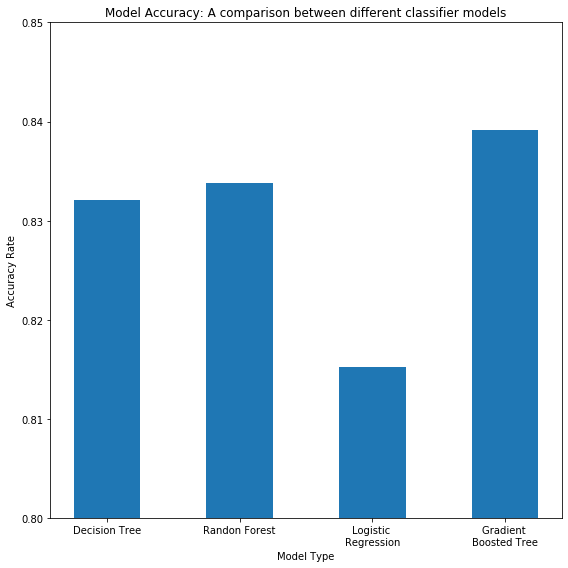

In [30]:
# prepare data
accuracy = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]
model_types = ["Decision Tree", "Randon Forest", "Logistic \nRegression", "Gradient \nBoosted Tree"]

# plot
bar_width = 0.5
y_pos = np.arange(len(model_types))
plt.figure(figsize=(8,8))

# change the limit of y-axis
plt.ylim(0.8, 0.85)

plt.bar(y_pos, accuracy, bar_width, align='center', color='C0')
plt.xticks(y_pos, model_types)

plt.xlabel('Model Type')
plt.ylabel('Accuracy Rate')
plt.title('Model Accuracy: A comparison between different classifier models')
plt.tight_layout()
plt.show()

> - In general, the four machine learning algorithms result in pretty impressive accuracy rates, ranging from 81% to almost 84%. In fact, there is no big difference between the models' performance
- Decision Tree and Random Forest Classifier Models have quite similar accuracy rates of just above 83%
- Gradient Boosted Tree Classifier performs the best in this problem (even though the distance to the second best model is miniscule), having accuracy rate of almost 84%
- Logistic Regression Classifier has the lowest accuracy rate of arounf 81%. However, this performance metric is still great

### Step 9: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm and explain how the accuracy of prediction can be improved
- In this section, we are going to compute the confusion matrix to find precision, recall and F1 score for each model
- Next, we are going to discuss how the accuracy of prediction can be improved

In [32]:
def Metrics(df):
    tp = df[(df.RainTomorrowIndex == 1.0) & (df.prediction == 1.0)].count()
    tn = df[(df.RainTomorrowIndex == 0.0) & (df.prediction == 0.0)].count()
    fp = df[(df.RainTomorrowIndex == 0.0) & (df.prediction == 1.0)].count()
    fn = df[(df.RainTomorrowIndex == 1.0) & (df.prediction == 0.0)].count()
    cm = [("True Possitive", tp), ("True Negative", tn), ("False Positive", fp), ("False Negative", fn)]
    precision = round(tp/(tp+fp),2)
    recall = round(tp/(tp+fn),2)
    f1 = round(2*((precision*recall)/(precision+recall)),2)
    return (cm, precision, recall, f1)

In [33]:
# We are going to extract the Prediction and Label for each algorithm

# decision tree
dt_df = dt_predictions.select(["RainTomorrowIndex","prediction"])

# random forest
rf_df = rf_predictions.select(["RainTomorrowIndex","prediction"])

# logistic regression
lr_df = lr_predictions.select(["RainTomorrowIndex","prediction"])

# GBT
gbt_df = gbt_predictions.select(["RainTomorrowIndex","prediction"])

#### Metrics of Decision Tree Algorithm

In [34]:
# Metrics of decision tree algorithm
print("Metrics of Decision Tree Algorithm:")
# confusion matrix
print("- Confusion Matrix:\n", Metrics(dt_df)[0])
# precision
print("- Precision: ", Metrics(dt_df)[1])
# recall
print("- Recall: ", Metrics(dt_df)[2])
# F1
print("- F1: ", Metrics(dt_df)[3])

Metrics of Decision Tree Algorithm:
- Confusion Matrix:
 [('True Possitive', 3570), ('True Negative', 31851), ('False Positive', 1207), ('False Negative', 5939)]
- Precision:  0.75
- Recall:  0.38
- F1:  0.5


#### Metrics of Random Forest Algorithm

In [35]:
# Metrics of random forest algorithm
print("Metrics of Random Forest Algorithm:")
# confusion matrix
print("- Confusion Matrix:\n", Metrics(rf_df)[0])
# precision
print("- Precision: ", Metrics(rf_df)[1])
# recall
print("- Recall: ", Metrics(rf_df)[2])
# F1
print("- F1: ", Metrics(rf_df)[3])

Metrics of Random Forest Algorithm:
- Confusion Matrix:
 [('True Possitive', 3497), ('True Negative', 31997), ('False Positive', 1061), ('False Negative', 6012)]
- Precision:  0.77
- Recall:  0.37
- F1:  0.5


#### Metrics of Logistric Regression

In [36]:
# Metrics of Logistic Regression algorithm
print("Metrics of Logistic Regression Algorithm:")
# confusion matrix
print("- Confusion Matrix:\n", Metrics(lr_df)[0])
# precision
print("- Precision: ", Metrics(lr_df)[1])
# recall
print("- Recall: ", Metrics(lr_df)[2])
# F1
print("- F1: ", Metrics(lr_df)[3])

Metrics of Logistic Regression Algorithm:
- Confusion Matrix:
 [('True Possitive', 3951), ('True Negative', 30751), ('False Positive', 2307), ('False Negative', 5558)]
- Precision:  0.63
- Recall:  0.42
- F1:  0.5


#### Metrics of Gradient Boosted Trees Algorithm

In [37]:
# Metrics of GBT algorithm
print("Metrics of Gradient Boosted Trees Algorithm:")
# confusion matrix
print("- Confusion Matrix:\n", Metrics(gbt_df)[0])
# precision
print("- Precision: ", Metrics(gbt_df)[1])
# recall
print("- Recall: ", Metrics(gbt_df)[2])
# F1
print("- F1: ", Metrics(gbt_df)[3])

Metrics of Gradient Boosted Trees Algorithm:
- Confusion Matrix:
 [('True Possitive', 4174), ('True Negative', 31547), ('False Positive', 1511), ('False Negative', 5335)]
- Precision:  0.73
- Recall:  0.44
- F1:  0.55


#### How we can improve the accuracy of the prediction
##### 1. Handling missing and outlier data
    - In the previous step, we were dealing with missing data by imputing the average values for numeric variables and imputing the higest frequent items for non-numeric variables
    - This might not be the most ideal method for handling missing data. For example, by replacing missing data with higest frequent items, the data is even more biased to the highest frequent items where it might not be true in real case
    - First, we need to investigate why the data is gone missing and which type of missing for each variable, including Missing At Random (MAR), Missing Completely As Random (MCAR), and Missing Not At Random (MNAR)
    - Second, after understanding the nature of missing, we should implement different methods on different kind of missing on each variable. For example: Mean, Median, Mode, Time Series, Linear Regression, etc.
    - Outliers should also be detected and removed before going to the training dataset

##### 2. Exploratory Data Analysis
    - We should explore our dataset first by both descriptive statistics and visualisation to deeply understand the interaction between variables, etc.
    - Gain insights about our dataset

##### 3. Feature engineering and selection
    - Here we haven't done a proper feature selection procedure
    - In order to improve the accuracy of prediction, we should consider to implement
        - Feature normalisation and transformation
        - Removal of non-significant variables to the prediction model, i.e. the independent variables that have low impact on the dependent variable
        - Stepwise methodology (forward, backward, hybrid)
        - Inspect whether we have multicollinearity among variables and handle
        - Removal of highly-correlated variable
        - Create of new features from the insights of EDA (interactive features, etc.)

##### 4. Cross-validation
    - Usually, our prediction model is biased towards the training data
    - Here we split the data into 70% and 30%, but we don't know which is the most ideal ratio and subsets
    - Cross-validation method (such as k-folds) divides the dataset into k-parts and implement train and test model on each subset each time
    - It helps to reduce bias of the model to the training data
    
#### 5. Other methods
    - Algorithm tuning
    - Ensemble methods
    - etc.

## This is the end of this assignment